In [1]:
!pip install numpy==1.23.0 --upgrade
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
raft-dask 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
lookback_data = np.load('/kaggle/input/bitcoin-price/loockback_data.npy')
df = pd.read_csv('/kaggle/input/bitcoin-price/data_new.csv')
target = pd.read_csv('/kaggle/input/bitcoin-price/target.csv')

In [3]:
target = target['target'][:-1]
df = df[:-1]
lookback_data = lookback_data[:-1]

In [4]:
target = target[15:]

In [5]:
# target = df['target']
df = df.drop(columns='target')

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df = standard_scaler.fit_transform(df)

In [7]:
import optuna
import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output

In [8]:
def DrawGraph(predict, target, title=''):
    plt.figure(figsize=(16, 12))
    plt.title(title)
    sns.set_style('darkgrid')
    sns.lineplot(x=range(len(predict)), y=target, color='black', label='True Value')
    sns.lineplot(x=range(len(predict)), y=predict, color='lightblue', label='Predicted Value', alpha=0.7, err_style='band')
    plt.legend()
    plt.show()

In [9]:
def SplitData(data, target, train_fraction=0.8):
    train_size = int(train_fraction * data.shape[0])
    
    X_train = data[:train_size]
    y_train = target[:train_size]
    
    X_test = data[train_size:]
    y_test = target[train_size:]
    
    return X_train, X_test, y_train, y_test
    

In [10]:
def FindBestParams(data, target, objective, train_fraction=0.8):
    X_train, X_val, y_train, y_val = SplitData(data, target, train_fraction)
    
    study = optuna.create_study(direction='minimize')
    f = lambda trial: objective(trial, X_train, y_train, X_val, y_val)
    study.optimize(f, n_trials=50, timeout=1200)

    return study.best_trial.params

In [11]:
def CountModelResult(X_test, y_test, results, model, model_name):
    pred = model.predict(X_test)
    
    result = pd.DataFrame(data={
        'RMSE': mean_squared_error(pred, y_test, squared=False),
        'MAPE': mean_absolute_percentage_error(pred, y_test) * 100,
        'MAE': mean_absolute_error(pred, y_test)
    },
    index=[model_name])
    results = results.append(result)

    print(f'RMSE for {model_name}: {mean_squared_error(pred, y_test, squared=False):.3f}')
    print(f'MAPE for {model_name}: {mean_absolute_percentage_error(pred, y_test) * 100:.3f}%')
    print(f'MAE for {model_name}: {mean_absolute_error(pred, y_test):.3f}')

    DrawGraph(pred, y_test, f'Results for {model_name}')

    return results

In [12]:
def ProcessModel(data, target, results, model, model_name, objective=None, train_fraction=0.8):
    train_size = int(train_fraction * data.shape[0])

    X_train = data[:train_size]
    y_train = target[:train_size]
    
    X_test = data[train_size:]
    y_test = target[train_size:]

    if objective is None:
        best_params = {}
    else:
        best_params = FindBestParams(X_train, y_train, objective)

    regressor = model(**best_params).fit(X_train, y_train)
    clear_output()
    results = CountModelResult(X_test, y_test, results, regressor, model_name)
    return results

In [13]:
from keras.models import Sequential
import keras.layers
import keras.optimizers
import keras.losses
import keras.regularizers

class LSTMModel:
    def __init__(self, n_layers=8, units=1024, n_epochs=300, activation='tanh', recurrent_activation='sigmoid', learning_rate=0.001, loss='mse', dropout=0.0, scaler=None):
        self.n_layers = n_layers
        self.units = units
        self.n_epochs = n_epochs
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.learning_rate = learning_rate
        self.loss = loss
        self.dropout = dropout
        self.is_fitted = False

        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler

        assert(units % (2**(n_layers - 1)) == 0)

    def compile(self):
        self.model = Sequential()

        units = self.units
        for iteration in range(self.n_layers - 1):
            if iteration == 0:
                self.model.add(keras.layers.Bidirectional(keras.layers.LSTM(
                    units=units,
                    input_shape=(15, 18),
                    return_sequences=True
                    )))
            else:
                self.model.add(keras.layers.Bidirectional(keras.layers.LSTM(
                    units=units,
                    return_sequences=True
                    )))
            self.model.add(keras.layers.Dropout(self.dropout))
                
            units //= 2
        
        self.model.add(keras.layers.Bidirectional(keras.layers.LSTM(
            units=units,
            return_sequences=False
            )))
        self.model.add(keras.layers.Dropout(self.dropout))
        
        self.model.add(keras.layers.Dense(1, activation='linear'))

        self.model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.RMSprop(learning_rate=self.learning_rate), metrics=['mae'])

        return self

    def fit(self, X, y, n_epochs=None, shuffle=False, verbose=1):
        if n_epochs is None:
            n_epochs = self.n_epochs

        y = np.array(y).reshape(-1, 1)  # Convert y to a numpy array

        self.scaler.fit(y)  # Fit the scaler on the training data only

        scaled_y = self.scaler.transform(y)  # Apply the scaler to the target variable

        self.compile()

        self.model.fit(X, scaled_y, epochs=n_epochs, shuffle=shuffle, verbose=verbose, batch_size=512)
        self.is_fitted = True

        return self

    def predict(self, X):
        assert self.is_fitted
        scaled_predictions = self.model.predict(X, verbose=0)  # Obtain scaled predictions
        predictions = self.scaler.inverse_transform(scaled_predictions)[:, 0]  # Invert the scaling
        return predictions

In [14]:
def LSTMObjective(trial, X_train, y_train, X_val, y_val):
    params = {
            'n_layers': trial.suggest_int('n_layers', 5, 9),
            'n_epochs': trial.suggest_int('n_epochs', 10, 25),
            'optimizer': trial.suggest_categorical('optimizer', ['sgd', 'adam', 'adamax', 'adagrad', 'adamW', 'rmsprop']),
            'units': trial.suggest_categorical('units', [512, 1024, 2048]),
            'dropout': trial.suggest_float('dropout', 0, 0.5),
        }

    if params['units'] < 2**(params['n_layers'] - 1):
        params['n_layers'] = 5

    regressor = LSTMModel(**params)

    regressor.fit(X_train, y_train, verbose=1)
    clear_output()

    pred = regressor.predict(X_val)
    return mean_squared_error(pred, y_val, squared=False)

In [15]:
for i in range(7):
    lookback_data[:, i, :], lookback_data[:, 14 - i, :] = lookback_data[:, 14 - i, :], lookback_data[:, i, :]

In [16]:
data_transformed = lookback_data.copy()

In [17]:
for i in range(data_transformed.shape[2]):
    data_transformed[:,:,i] = StandardScaler().fit_transform(data_transformed[:,:,i])

In [18]:
model = LSTMModel(n_layers=2, units=64, n_epochs=150, learning_rate=0.0009, dropout=0.25)

In [19]:
X_train, X_val, y_train, y_val = SplitData(data_transformed, target)

In [20]:
model.fit(X_train, y_train)

Epoch 1/150
374/374 [==============================] - 16s 12ms/step - loss: 0.0049 - mae: 0.0698
Epoch 2/150
374/374 [==============================] - 5s 12ms/step - loss: 0.0015 - mae: 0.0391
Epoch 3/150
374/374 [==============================] - 5s 13ms/step - loss: 0.0011 - mae: 0.0328
Epoch 4/150
374/374 [==============================] - 5s 13ms/step - loss: 8.9119e-04 - mae: 0.0297
Epoch 5/150
374/374 [==============================] - 5s 14ms/step - loss: 7.8013e-04 - mae: 0.0278
Epoch 6/150
374/374 [==============================] - 5s 13ms/step - loss: 7.1441e-04 - mae: 0.0265
Epoch 7/150
374/374 [==============================] - 5s 12ms/step - loss: 6.5038e-04 - mae: 0.0253
Epoch 8/150
374/374 [==============================] - 5s 13ms/step - loss: 5.8349e-04 - mae: 0.0240
Epoch 9/150
374/374 [==============================] - 5s 12ms/step - loss: 5.3772e-04 - mae: 0.0230
Epoch 10/150
374/374 [==============================] - 5s 12ms/step - loss: 5.0637e-04 - mae: 0.0223


In [21]:
pred = model.predict(X_val)

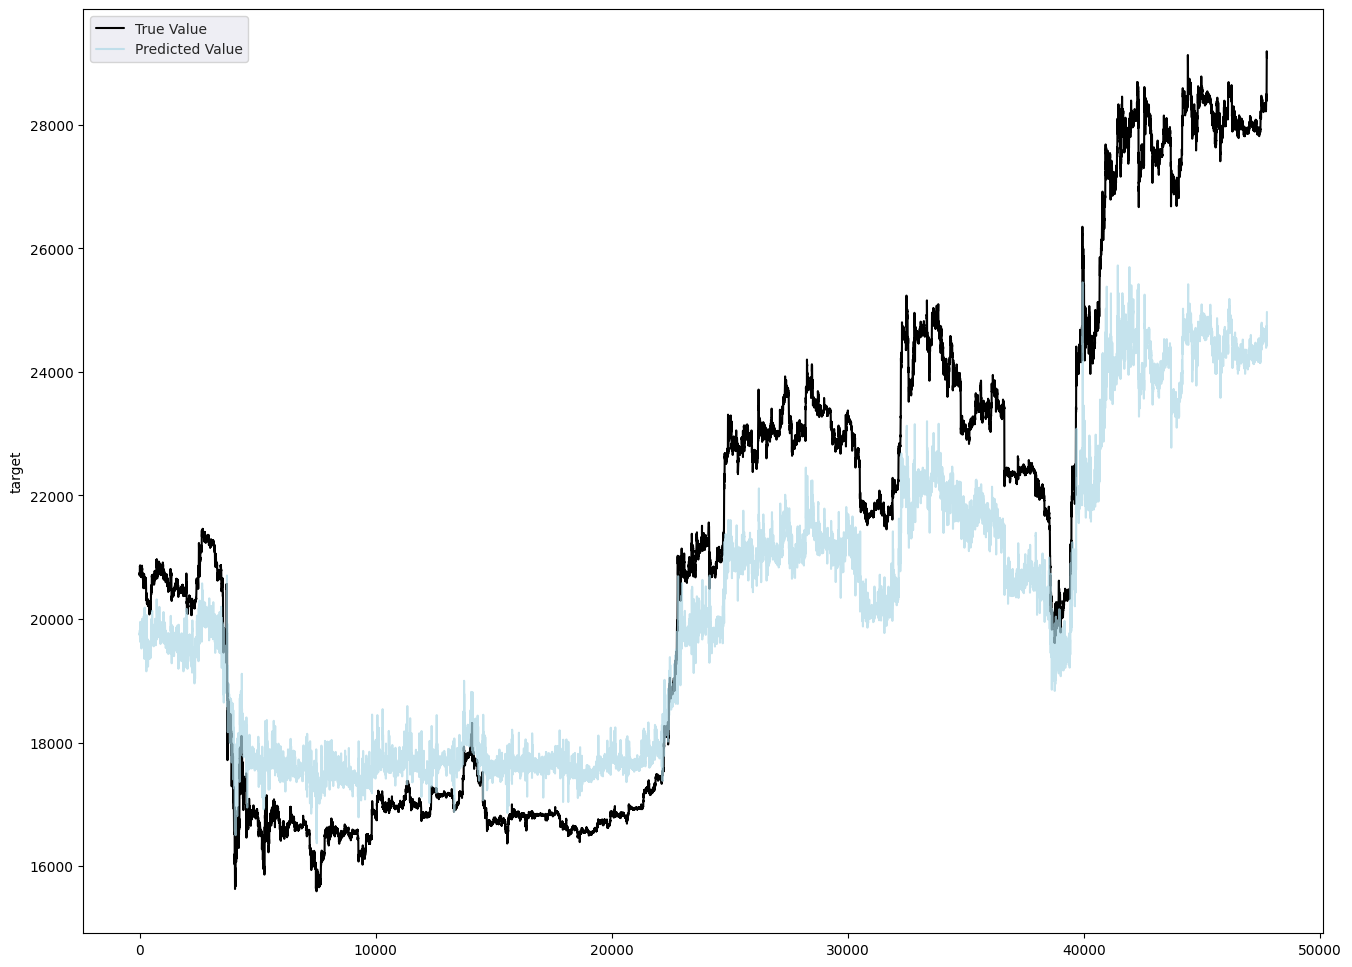

In [22]:
DrawGraph(pred, y_val)

In [23]:
pred = model.predict(X_train)

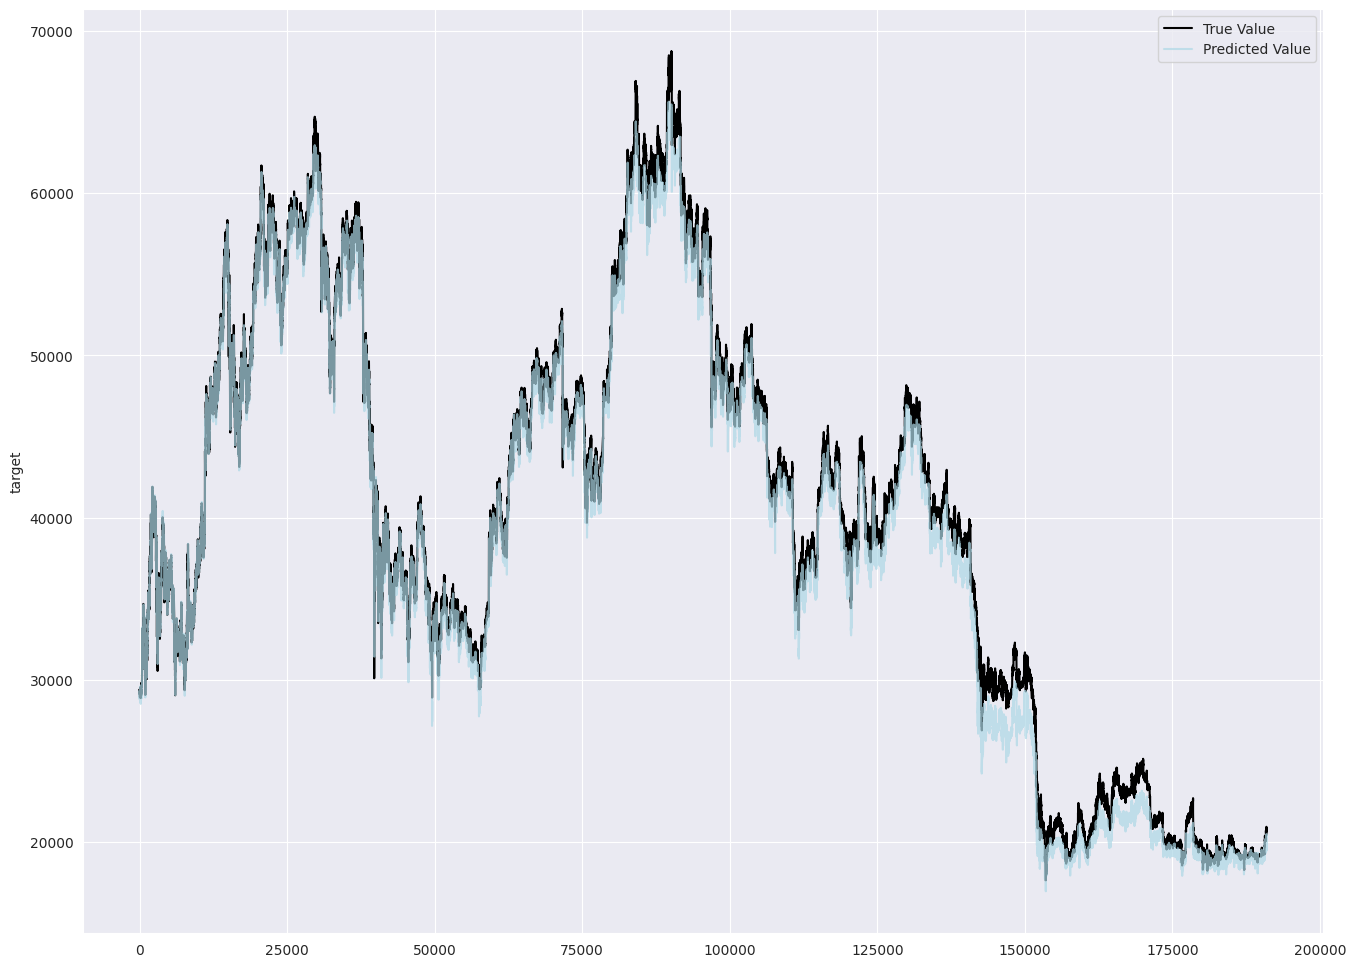

In [24]:
DrawGraph(pred, y_train)

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for LSTM: 1873.317
MAPE for LSTM: 7.474%
MAE for LSTM: 1581.108


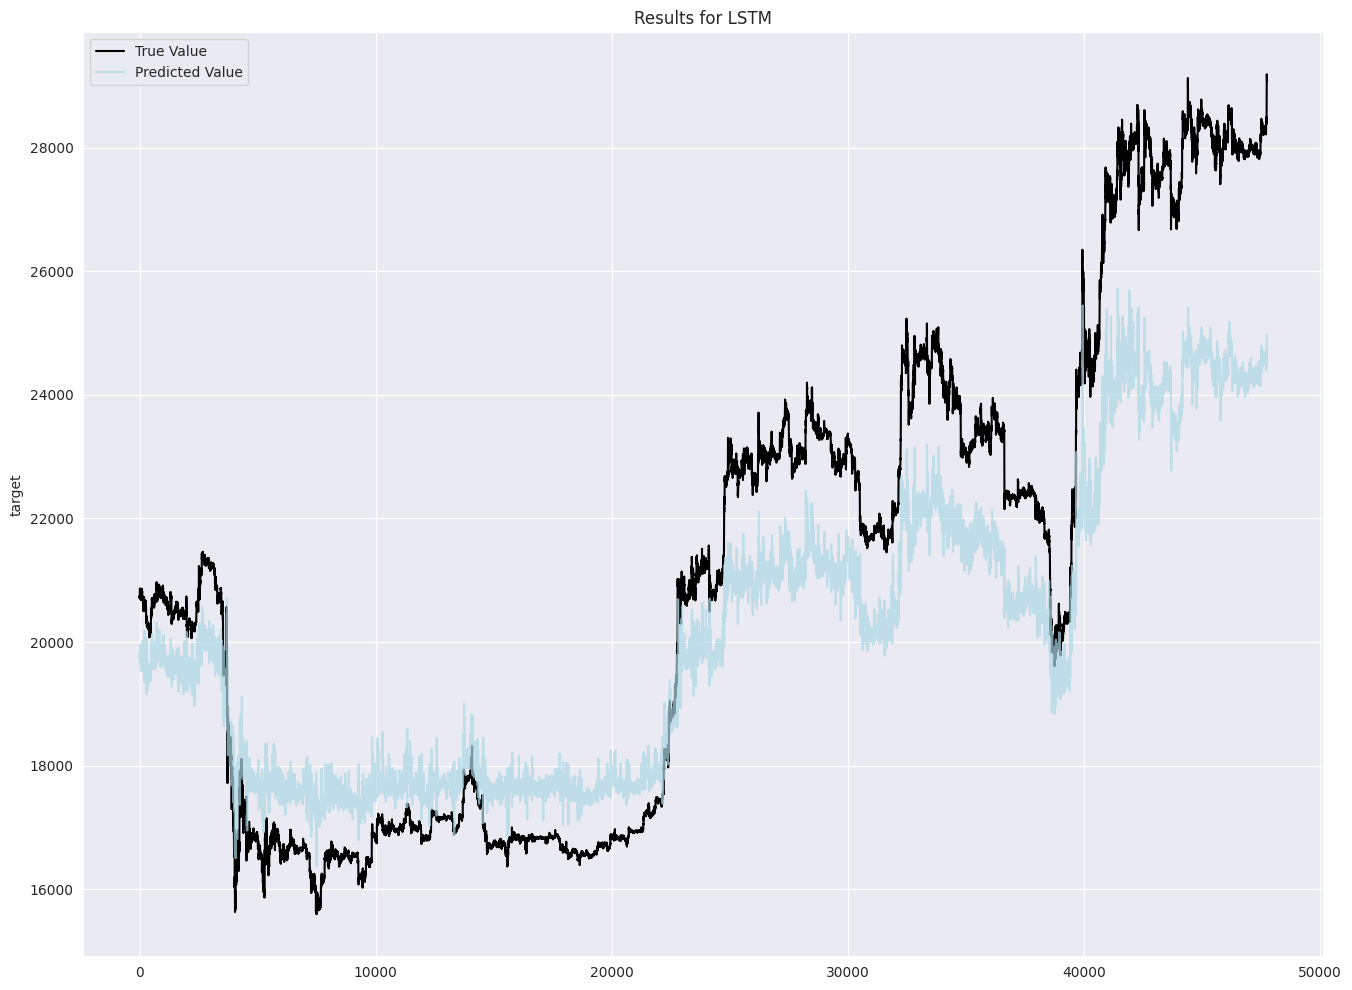

In [25]:
results = pd.DataFrame()
results = CountModelResult(X_val, y_val, results, model, 'LSTM')

In [26]:
results

,RMSE,MAPE,MAE
LSTM,1873.317262,7.473681,1581.108419


In [27]:
model.model.save('/kaggle/working/LSTM2_64')

In [28]:
pred

array([28828.871, 28891.691, 29010.426, ..., 19737.742, 19846.244,
       20052.05 ], dtype=float32)